In [ ]:
'''
Copyright 2020 Vignesh Kotteeswaran <iamvk888@gmail.com>
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

Sun Aug 16 13:01:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip -q '/content/drive/My Drive/personal/temp/vehicle_train_labelled.zip'
!unzip -q '/content/drive/My Drive/personal/temp/vehicle_test_labelled.zip'

In [ ]:
!pip install albumentations==0.4.2

In [1]:
%tensorflow_version 1.x 
%matplotlib inline
import cv2
import pandas as pd
from glob import glob
import keras
from keras import backend as K
from keras.preprocessing.image import *
from keras.optimizers import Adam, SGD
from keras.callbacks import *
from keras import backend as K
from keras.models import *
from keras.layers import * 
from keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from yolo2rectanglev3 import yolo2rectangle ,yolotxt2rectangle
from ssd_input_encoder import SSDInputEncoder
from ssd_output_decoder import decode_detections
from matplotlib import pyplot as plt
from model import build_model
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_ssd_loss import SSDLoss
from matplotlib import patches
import albumentations as A
from albumentations import BboxParams
from keras.callbacks import ModelCheckpoint
from custom_aug import *
from keras.applications.nasnet import preprocess_input
from utils import box_filter,bb_sorter
from ssdbox2yolotxtv8 import convert
import os
import shutil

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
#globals 
# n_classes is 1 higher than YOLO since class  0 is background in SSD

redux=1.0
size=(384,640,3)
width=size[0]
height=size[1]
channels=size[2]
batch_size=8
seed=23
set_=0
np.random.seed(seed)
predictor_sizes=[(96,160),(48,80),(24,40),(12,20)]
num_boxes=12240
chars=['vehicle',0]

n_classes=len(chars)-1
last_class=n_classes
print(len(chars))

image_size=(size[0],size[1],size[2])
img_height=size[0]
img_width=size[1]
l2_regularization=0.0
scales=[i for i in np.linspace(0.1,0.9,len(predictor_sizes)+1)]
print('scales:',scales)
aspect_ratios_global=None
aspect_ratios_per_layer=[[0.18,0.26,1,1.3,2],
                                     [2.2, 0.31, 0.45,1.0,1.7],
                                     [0.22,1.2,1,1.6,2,2.3],
                                     [0.19, 2.0, 0.5,4,3.0]]

two_boxes_for_ar1=True
steps=None
offsets=None
clip_boxes=False
variances=[1, 1, 1,1]
normalize_coords=True
subtract_mean=None
divide_by_stddev=None


Enter the set:0
2
scales: [0.1, 0.30000000000000004, 0.5, 0.7000000000000001, 0.9]


In [ ]:
#os.remove('img/2020-03-06 12_22_23.308683.txt')
for i in sorted(glob('/content/vehicle_train_labelled/*.txt')):
  #print(i)
  try:
    data=yolotxt2rectangle(i,y_height=img_height,x_height=img_width,last_class=last_class)

    for x,y in zip(data[:,1],data[:,3]):
      if x>=y:
        print(i)
        if os.path.exists(i):
          os.remove(i)

    for x,y in zip(data[:,2],data[:,4]):
      if x>=y:
        print(i)
        if os.path.exists(i):
          os.remove(i)

  except ValueError :
    print(i)
    if os.path.exists(i):
          os.remove(i)

  try:
    load_img(path=i.strip('.txt')+'.png',target_size=(50,50),color_mode='rgb')
  except:
    print(i)
    if os.path.exists(i):
          os.remove(i)
          os.remove(i.strip('.txt')+'.png')

/content/big/frame 19000.txt


In [ ]:
train_fnames=sorted(glob('/content/vehicle_train_labelled/*.txt'))+sorted(glob('/content/big/*.txt'))
val_fnames=sorted(glob('/content/vehicle_test_labelled/*.txt'))
test_fnames=val_fnames

print(train_fnames[:10])
print(val_fnames[:10])
print(len(train_fnames),len(val_fnames))

In [4]:
class datagen(Sequence):

  def __init__(self,train_im_path,augmentations,batch_size,nclasses,predictor_sizes,img_size=256,nchannels=3,normalize_img=False,shuffle=True):
    self.batch_size=batch_size
    self.train_im_paths=train_im_path
    self.img_size=img_size
    print(self.img_size)
    self.nchannels=nchannels
    self.shuffle=shuffle
    self.nclasses=nclasses
    self.predictor_sizes=predictor_sizes
    self.encoder=SSDInputEncoder(img_height=img_height,img_width=img_width,n_classes=n_classes,predictor_sizes=predictor_sizes,scales=scales,aspect_ratios_global=aspect_ratios_global,aspect_ratios_per_layer=aspect_ratios_per_layer,two_boxes_for_ar1=two_boxes_for_ar1,steps=steps,offsets=offsets,clip_boxes=clip_boxes,variances=variances,matching_type='multi',pos_iou_threshold=0.5,neg_iou_limit=0.3,border_pixels='half',coords='centroids',normalize_coords=normalize_coords,background_id=0)
    ## maps bw 0-1
    self.normalize_img=normalize_img
    self.augmentations=augmentations
    if self.augmentations!=None:
      print('Augs used:',self.augmentations)
    self.on_epoch_end()
    print('Num images found : {}'.format(len(self.train_im_paths)))
  def __len__(self):
    return int(np.ceil(len(self.train_im_paths) / self.batch_size))

  def __getitem__(self,index):
    if self.augmentations!=None:
      self.aug=self.get_aug(self.augmentations)
    indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

    list_IDs_im = [self.train_im_paths[k] for k in indexes]
    
    try:
      X,y= self.data_generation(list_IDs_im,'rgb')
    except ValueError:
      print('here')
      X,y=self.prev_X,self.prev_Y
    #except IndexError:
    #X,y=self.prev_X,self.prev_Y
    
      #print('problem averted')
    #y= self.label_generation(list_IDs_im)
    return X,y
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.train_im_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def get_aug(self,aug, min_area=0., min_visibility=0.):
    return A.Compose(aug, A.BboxParams(format='pascal_voc', min_area=min_area, 
                                       min_visibility=min_visibility, label_fields=['category_id']))
  
  def data_generation(self,list_IDs,color_mode):
    Y=[]

    if color_mode=='rgb':
      X = np.empty((len(list_IDs),img_height,img_width, 3))

    if color_mode=='grayscale':
      X = np.empty((len(list_IDs),img_height,img_width, 1))

    for count,i in enumerate(list_IDs):
      self.curr_name=i
      self.flag=False
      if self.augmentations!=None:
        self.shift_thresh=np.random.uniform(low=0.01,high=0.25,size=(1,))
      #print(i)
      x=img_to_array(load_img(path=i.strip('.txt')+'.png',target_size=(img_height,img_width),color_mode=color_mode)).astype(np.uint8)
      box=yolotxt2rectangle(i,y_height=img_height,x_height=img_width,last_class=last_class)
      '''
      if count==1 and self.augmentations!=None:
        x,box=vshift(x,box,percentage=self.shift_thresh/3.0)

      if count==2 and self.augmentations!=None:
        x,box=hshift(x,box,percentage=self.shift_thresh)

      if count==3 and self.augmentations!=None:
        x,box=hshift(x,box,percentage=self.shift_thresh)
      #print(self.augmentations)
      '''
      if len(box)<1:
         self.flag=True
         x=img_to_array(load_img(path=i.strip('.txt')+'.jpg',target_size=(img_height,img_width),color_mode=color_mode)).astype(np.uint8)
         box=yolotxt2rectangle(i,y_height=img_height,x_height=img_width)
      
      self.curr_box=box
      if self.augmentations!=None:
        #assert(len(box)>0),'degenerate entry found'
        annotations = {'image': x, 'bboxes': [i for i in box[:,1:]], 'category_id': [i for i in box[:,0]]}
        augmented = self.aug(**annotations)
        x=augmented['image']

        box_array=np.empty(shape=(len(augmented['bboxes']),5))
        box_array[:,1:]=np.array(augmented['bboxes'])
        box_array[:,0]=np.array(augmented['category_id'])

        Y.append(box_array)

      else:
        Y.append(box) 

      if color_mode=='rgb':
        #x=A.Equalize(p=1.0).apply(x)
        x=np.expand_dims(x,axis=0)
      if color_mode=='grayscale':
        #x=A.Equalize(p=1.0).apply(x)
        x=np.expand_dims(x,axis=0)
      self.curr_frame=x
      X[count]=x
    try:
      self.prev_X,self.prev_Y=np.uint8(X),self.encoder(Y)
    except IndexError:
      print(i)
    return np.uint8(X),self.encoder(Y)
  
  def scaler(self,x):
    x[x>0]=1
    return x
  
  def normalize(self,x):
    return np.array(x,dtype=np.float32)/255.0


In [5]:
augmentations=[A.Rotate(limit=2,p=0.2),
               A.Flip(p=0.2),
               #A.ShiftScaleRotate(rotate_limit=2,p=0.1,border_mode=cv2.BORDER_CONSTANT,mask_value=0),
               A.ShiftScaleRotate(p=0.2,border_mode=cv2.BORDER_CONSTANT),
               #A.JpegCompression(p=0.1,quality_lower=5,quality_upper=10),
               A.RandomBrightnessContrast(p=0.1),
               A.GaussianBlur(p=0.1),
               #A.RandomSizedBBoxSafeCrop(width=img_width,height=img_height,p=0.1),
               A.RGBShift(p=0.1)
               ]  
val_augmentations=None

In [6]:
#train_im_path,augmentations,batch_size,nclasses,num_boxes,predictor_sizes,img_size=256,nchannels=3,normalize_img=False,shuffle=True
gen=datagen(train_fnames,None,batch_size,n_classes,predictor_sizes,image_size,channels,shuffle=True)
aug_gen=datagen(train_fnames,augmentations,batch_size,n_classes,predictor_sizes,image_size,channels,shuffle=True)
valgen=datagen(val_fnames,val_augmentations,batch_size,n_classes,predictor_sizes,image_size,channels,shuffle=False)
testgen=datagen(val_fnames,val_augmentations,1,n_classes,predictor_sizes,image_size,channels,shuffle=True)

(384, 640, 3)
Num images found : 479
(384, 640, 3)
Augs used: [Rotate(always_apply=False, p=0.2, limit=(-2, 2), interpolation=1, border_mode=4, value=None, mask_value=None), Flip(always_apply=False, p=0.2), ShiftScaleRotate(always_apply=False, p=0.2, shift_limit=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=0, value=None, mask_value=None), RandomBrightnessContrast(always_apply=False, p=0.1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True), GaussianBlur(always_apply=False, p=0.1, blur_limit=(3, 7)), RGBShift(always_apply=False, p=0.1, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20))]
Num images found : 479
(384, 640, 3)
Num images found : 88
(384, 640, 3)
Num images found : 88


In [ ]:
id_=np.random.randint(0,len(aug_gen))
#id_=277
print(id_)
img,arr=aug_gen[id_]

for i in range(batch_size):
  
  dpred=decode_detections(np.expand_dims(arr[i],axis=0),confidence_thresh=0.5,iou_threshold=0.1,top_k=200,input_coords='centroids',normalize_coords=normalize_coords,img_height=img_height,img_width=img_width)[0]
  #print(dpred[:,-4:])
  for class_,coords in zip(dpred[:,0],dpred[:,-4:]):
    xmin,ymin,xmax,ymax=[int(i) for i in coords]
    #print(class_,xmin,ymin,xmax,ymax)
    cv2.rectangle(img[i], (int(xmin),int(ymin)), (int(xmax),int(ymax)), (0,0,255), 2)
    plt.title(str(dpred[:,0]))
  if img[i].shape[-1]==1:
    img_=np.squeeze(img[i])
    plt.imshow(img_,cmap='gray')
    plt.show()
  else:
    plt.imshow(img[i])
    plt.show()

In [ ]:
id_=np.random.randint(0,len(valgen))
img,arr=valgen[id_]

for i in range(len(arr)):
  #print(arr[i].shape)
  dpred=decode_detections(np.expand_dims(arr[i],axis=0),confidence_thresh=0.5,iou_threshold=0.1,top_k=200,input_coords='centroids',normalize_coords=normalize_coords,img_height=img_height,img_width=img_width)[0]
  #print(dpred[:,-4:])
  for coords in dpred[:,-4:]:
    xmin,ymin,xmax,ymax=[int(i) for i in coords]
    plt.title(str(dpred[:,0]))
    #print(xmin,ymin,xmax,ymax)
    cv2.rectangle(img[i], (int(xmin),int(ymin)), (int(xmax),int(ymax)), (0,0,255), 2)
  if img[i].shape[-1]==1:
    img_=np.squeeze(img[i])
    plt.imshow(img_,cmap='gray')
    plt.show()
  else:
    plt.imshow(img[i])
    plt.show()

In [11]:
arr[0].shape

(123120, 14)

In [ ]:
K.clear_session()
model=build_model(image_size=image_size,
                    redux=redux,
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios_global,
                    aspect_ratios_per_layer=aspect_ratios_per_layer,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=subtract_mean,
                    divide_by_stddev=divide_by_stddev)

print(model.summary())
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0,beta=1.0)
model.compile(loss=ssd_loss.compute_loss,optimizer='adam')

In [127]:
K.clear_session()

def temp(x,y):
  return keras.losses.binary_crossentropy(x,y)


model=load_model('vehicle_temp3.h5',custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss':ssd_loss.compute_loss})
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0,beta=1.0)
model.compile(loss=ssd_loss.compute_loss,optimizer='adam')

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [148]:
K.set_value(model.optimizer.lr,7.5e-4)

In [9]:
class mAP(keras.callbacks.Callback):
    
    '''
    A custom callback to compute test
    mAP score for every epoch
    '''
    
    def __init__(self):
        super(mAP, self).__init__()
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        
        
    def accumulate(self,filepath):
      img=img_to_array(load_img(path=filepath[:-4]+'.png',target_size=(img_height,img_width),color_mode='rgb'))
      img=np.expand_dims(img,axis=0)
      iou_threshold=0.25
      confidence_thresh=0.25
      pred=self.model.predict(img)
      dpred=decode_detections(pred,confidence_thresh=confidence_thresh,iou_threshold=iou_threshold,top_k=200,input_coords='centroids',normalize_coords=normalize_coords,img_height=img_height,img_width=img_width)[0]
      box=box_filter(dpred,thresh=0.25)
      assert(os.path.exists('gt')),'No ground truth folder found'
      shutil.copy(filepath[:-4]+'.txt','gt')
      assert(os.path.exists('det')),'No detection folder found'

      try:
        with open('det/{}.txt'.format(filepath.split('/')[-1][:-4]),'a')as f:
          for i in convert(box,x_height=height,y_height=width):
              for count,item in enumerate(i):
                  if count==0:
                      f.write(str(item.astype(np.int32)).strip("[] ")+' ')
                  else:
                      f.write(str(np.round(item,3)).strip("[] ")+' ')
              f.write('\n')

      except IndexError:
        #print(filepath,box.shape)
        pass
        
    
    def compute_mAP(self,filedir,reset=False):
      if reset:
        os.system('rm -r gt')
        os.system('rm -r det')
        os.system('mkdir gt')
        os.system('mkdir det')
    
      for file in (sorted(glob(filedir+'/*.txt'))):
          try:
            #print(file)
            self.accumulate(file)
          except ValueError:
            print(file)
       
      os.system('python3 pascalvoc.py -gt gt -det det -gtcoords rel -detcoords rel -t 0.5 -gtformat xywh -detformat xywh -imgsize {},{} -np -t 0.5'.format(width,height))
      with open('results/results.txt','r') as f:
          return f.read().split('mAP:')[-1]

    #def on_epoch_end(self, epoch, logs=None):
    #  self.compute_mAP('/content/img_hrithik',reset=True)
        
    def on_test_end(self, batch, logs=None):
      #print('val mAP:',self.compute_mAP('/content/val',reset=True))
      testmAP=self.compute_mAP('/content/vehicle_test_labelled',reset=True).strip(' ')
      if float(testmAP.strip('%'))>71.0:
        model.save('models/temp_{}.h5'.format(testmAP))
      print('test mAP:',testmAP)

In [13]:
#[mAP()]
intial_epoch=20
final_epoch=21
print('lr:',K.eval(model.optimizer.lr))
print('augs used:',augmentations)
print('val_augs used:',val_augmentations)
print('num train samples:',len(aug_gen)*batch_size)
print('num val samples:',len(valgen)*batch_size)
history=model.fit_generator(aug_gen,steps_per_epoch=len(aug_gen),
                            validation_data=valgen,
                            validation_steps=len(valgen),
                            callbacks=[mAP()],
                            epochs=final_epoch,
                            initial_epoch=intial_epoch,
                            verbose=1)

#1.12
#1.83 1.85 22


lr: 0.001
augs used: [Rotate(always_apply=False, p=0.2, limit=(-2, 2), interpolation=1, border_mode=4, value=None, mask_value=None), Flip(always_apply=False, p=0.2), ShiftScaleRotate(always_apply=False, p=0.2, shift_limit=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=0, value=None, mask_value=None), RandomBrightnessContrast(always_apply=False, p=0.1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True), GaussianBlur(always_apply=False, p=0.1, blur_limit=(3, 7)), RGBShift(always_apply=False, p=0.1, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20))]
val_augs used: None
num train samples: 480
num val samples: 88
Epoch 21/21
60/60 [==============================] - 161s 3s/step - loss: 0.9492 - val_loss: 1.0229


In [ ]:
model.evaluate_generator(valgen,callbacks=[mAP()])

In [ ]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = np.maximum(boxA[0], boxB[0])
    yA = np.maximum(boxA[1], boxB[1])
    xB = np.minimum(boxA[2], boxB[2])
    yB = np.minimum(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)

    #print ('intersection:',interArea)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    #print ('boxA:',boxAArea)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    #print ('boxB:',boxBArea)
        
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / (boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    
    return iou
     
def nms(box):
  unq_class=np.unique(box[:,0])
  for i in unq_class:
    curr_box=[]
    for j in box:
      if j[0]==i:
        curr_box.append(j)
    ious=[]
    for j in range(len(curr_box)-1):
      ious.append(compute_iou(box[j,2:],box[j+1,2:]))
    print(ious)

def box_filter(box,thresh):
  #print('num boxes:',len(box))
  box_copy=np.copy(box)
  indices=[]
  for i in range(len(box)):
    for j in range(len(box)):
      if i!=j and i<len(box) and j<len(box):
        iou=compute_iou(box[i,2:],box[j,2:])
        #print(iou,i,j,chars[int(box[i,0])-1],chars[int(box[j,0])-1])
      
        if iou>thresh:
          index=np.argmin(np.array([box[i,1],box[j,1]]))
          #print(index,box[i],box[j])
          if index==0:
            #print('*** deleting_'+chars[int(box[i,0])-1])
            #box_del=np.delete(box_copy,i,axis=0)
            indices.append(i)

          if index==1:
            #print('*** deleting_'+chars[int(box[j,0])-1])
            #box_del=np.delete(box_copy,j,axis=0)
            indices.append(j)
      
  #print(indices)
  return np.delete(box,indices,axis=0)



59
(384, 640, 3)
6
(378, 672, 3) 1.0 640 672 198 229
(378, 672, 3) 1.0 672 672 77 98
(378, 672, 3) 1.0 344 392 137 168
(378, 672, 3) 1.0 670 672 76 101
(378, 672, 3) 1.0 672 672 100 132
(378, 672, 3) 1.0 672 672 88 113
############
1.0 263 43 278 60
1.0 261 69 273 90
1.0 379 119 440 175
1.0 537 132 603 172
1.0 443 139 505 195
1.0 602 178 635 229
1.0 195 233 226 290


"\nfor i in range(len(rois)):\n  ax[2+i].set_title('RoI')\n  #print(rois[i].shape)\n  ax[2+i].imshow(rois[i])\nplt.show()\nprint(testgen.curr_name)\n"

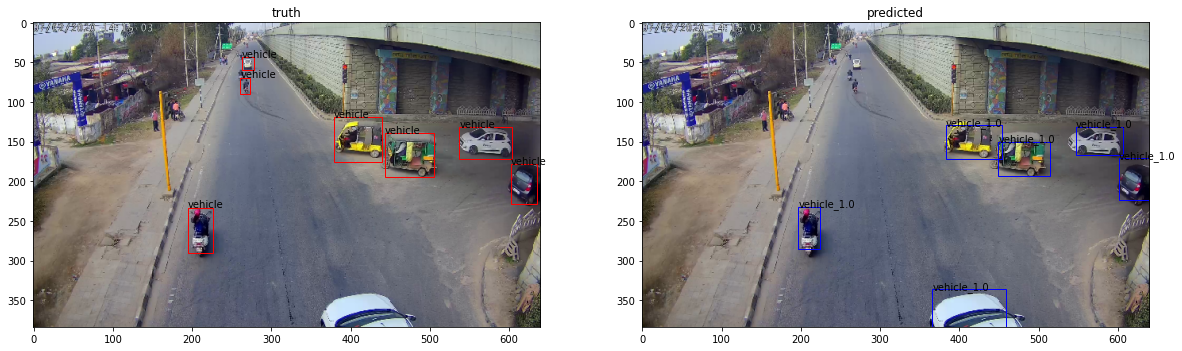

In [146]:
id_=np.random.randint(0,len(testgen))
#id_=0
print(id_)
img,arr=(testgen[id_])
#id_+=1
print(img[0].shape)
pred=model.predict(np.expand_dims(img[0],axis=0))
dpred=decode_detections(pred,confidence_thresh=0.9,iou_threshold=0.2,top_k=30,input_coords='centroids',normalize_coords=normalize_coords,img_height=img_height,img_width=img_width)[0]

#dpred=box_filter(dpred,0.1)
print(len(dpred))
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,20))
#print('filtered:',dpred)

rois=[]
counter=0
raw_img=img_to_array(load_img(path=testgen.curr_name[:-4]+'.png',color_mode='rgb')).astype(np.uint8)
for class_,score,coords in zip(dpred[:,0],dpred[:,1],dpred[:,-4:]):
  score=np.round(score,decimals=3)
  xmin,ymin,xmax,ymax=[int(i) for i in coords]
  #print(xmin,ymin,xmax,ymax)
  ax[1].set_title('predicted')
  #cv2.rectangle(img[0], (int(xmin),int(ymin)), (int(xmax),int(ymax)), (0,0,255), 2)
  ax[1].add_patch(patches.Rectangle((xmin,ymin),xmax-xmin, ymax-ymin,fill=False,edgecolor='b'))
  ax[1].text(xmin,ymin,str(chars[int(class_)-1])+'_'+str(score))
  xmin=np.clip(int(raw_img.shape[1]*(xmin/img_height)),0,raw_img.shape[1])
  xmax=np.clip(int(raw_img.shape[1]*(xmax/img_height)),0,raw_img.shape[1])
  ymin=np.clip(int(raw_img.shape[0]*(ymin/img_width)),0,raw_img.shape[0])
  ymax=np.clip(int(raw_img.shape[0]*(ymax/img_width)),0,raw_img.shape[0])
  print(raw_img.shape,class_,xmin,xmax,ymin,ymax)
  rois.append(raw_img[ymin:ymax,xmin:xmax])
  counter+=1
ax[1].imshow(img[0])
print('############')
dorg=decode_detections(np.expand_dims(arr[0],axis=0),confidence_thresh=0.45,iou_threshold=0.2,top_k=200,input_coords='centroids',normalize_coords=normalize_coords,img_height=img_height,img_width=img_width)[0]
#print(dorg)
for class_,coords in zip(dorg[:,0],dorg[:,-4:]):
  xmin,ymin,xmax,ymax=[int(i) for i in coords]
  #print(xmin,ymin,xmax,ymax)
  #plt.title(str(sorter(dpred)))
  ax[0].set_title('truth')
  #cv2.rectangle(img[0], (int(xmin),int(ymin)), (int(xmax),int(ymax)), (0,0,255), 2)
  ax[0].add_patch(patches.Rectangle((xmin,ymin),xmax-xmin, ymax-ymin,fill=False,edgecolor='r'))
  print(class_,xmin,ymin,xmax,ymax)
  ax[0].text(xmin,ymin,str(chars[int(class_)-1]))
ax[0].imshow(img[0])

In [147]:
model.save('vehicle_detect.h5',include_optimizer=False)